# Hybrid integrations with TRACE
REBOUND comes with several integrators, each of which has its own advantages and disadvantages. TRACE is a hybrie time-reversible integrator that is based on the algorithm described by Hernandez & Dehnen (2023). It uses a symplectic Wisdom-Holman integrator when particles are far apart from each other and switches over to a high order integrator during close encounters. Specifically, TRACE uses the efficient WHFast and BS integrators internally.

Let's start out by showcasing the problem with traditional fixed timestep integrators such as WHFast. We setup a simulation of the outer solar system and increase the masses of the planets by a factor of 50. 

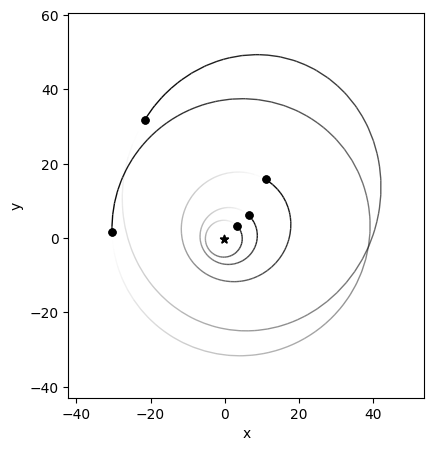

In [12]:
import math
import numpy as np
import rebound, rebound.data
import matplotlib.pyplot as plt
%matplotlib inline
sim = rebound.Simulation()
rebound.data.add_outer_solar_system(sim) # add some particles for testing
for i in range(1,sim.N):
    sim.particles[i].m *= 50.
sim.integrator = "WHFast" # This will end badly!
sim.dt = sim.particles[1].P * 0.002 # Timestep a small fraction of innermost planet's period
sim.move_to_com()
E0 = sim.energy() # Calculate initial energy 
rebound.OrbitPlot(sim)

Let us integrate this system for a few hundred years. An instability will occur. We can then measure the energy error, which is a good estimate as to how accurate the integration was.

In [2]:
sim.integrate(600*2.*math.pi)
E1 = sim.energy()
print("Relative energy error with WHFast: %f"%((E0-E1)/E0))

Relative energy error with WHFast: 42.011050


An energy error that large means we basically go it wrong completely. Let's try this again but use TRACE.

In [17]:
sim = rebound.Simulation()
rebound.data.add_outer_solar_system(sim) # add some particles for testing
for i in range(1,sim.N):
    sim.particles[i].m *= 50.
sim.integrator = "trace" 
sim.dt = sim.particles[1].P * 0.002 # Timestep a small fraction of innermost planet's period
sim.move_to_com()
E0 = sim.energy() # Calculate initial energy

Nout = 1000
times = np.linspace(0, 600*2*math.pi, Nout)
errors = np.zeros(Nout)

for i, t in enumerate(times):
    errors[i] = (sim.energy()-E0)/E0
    sim.integrate(t, exact_finish_time=0)
#sim.integrate(600*2.*math.pi)
E1 = sim.energy()
print("Relative energy error with TRACE: %e"%((E1-E0)/E0))

Relative energy error with TRACE: -2.443053e-03


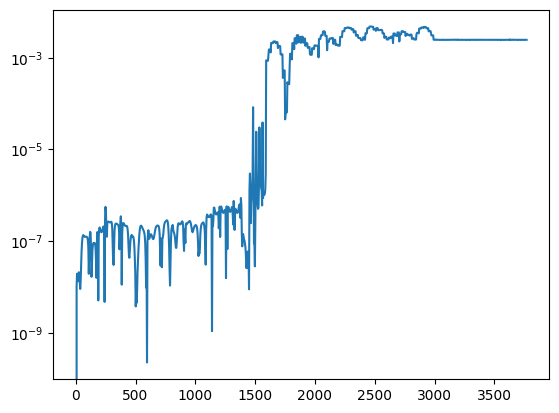

In [21]:
plt.plot(times, np.abs(errors))
plt.yscale('log')

As you can see, TRACE is able to integrate this system with much better accuracy. When a close encounter occurs, it automatically (and reversibly!) switches to the BS integrator. When there is no close encounter, you still get all the benefits in terms of speed and accuracy from WHFAST.

There are a few options to adjust TRACE. First of all, because it uses BS internally, you may want to set the BS tolerances. This ensures that IAS15 never stalls while it is tries to resolve one very close encounter and can be done with the following command:

In [4]:
# Sets the minimal timestep to a fraction of the global timestep
sim.ri_ias15.min_dt = 1e-4 * sim.dt  

You also may want to change the critical distance at which MERCURIUS switches over from pure WHFast to IAS15. This is expressed in units of Hill radii. The default is 3 Hill radii, in the following we change it to 5 Hill radii:

In [5]:
sim.ri_mercurius.r_crit_hill = 5